<a href="https://colab.research.google.com/github/jagadeesh3093/cancer_classification/blob/main/JSNV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
import warnings

print("Imoprted Complitely!")

Imoprted Complitely!


Mounted at /content/drive


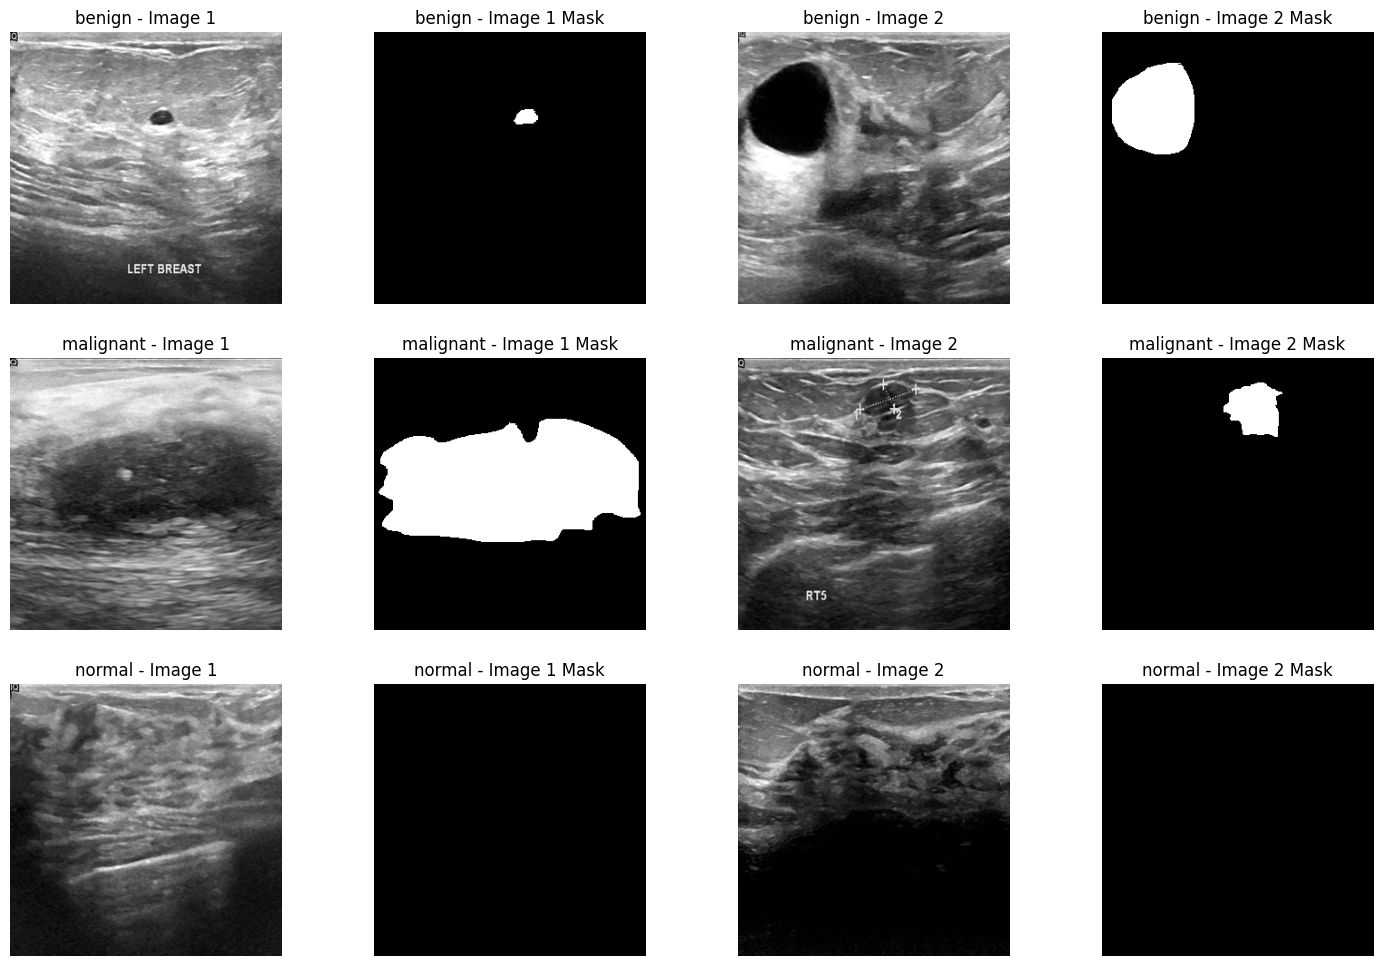

In [ ]:
labels = ['benign', 'malignant', 'normal']
# Mount Google Drive if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Define data path and categories
data_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/'
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

desired_width = 300
desired_height = 300

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    image_files = sorted(image_files)

    for j in range(4):
        if j < len(image_files):
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.LANCZOS)

            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

In [ ]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

In [ ]:
working_dir = '/content/drive/MyDrive/working'

for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("working output path cleared!")

working output path cleared!


In [ ]:
train_dir = '/content/drive/MyDrive/working/train'
val_dir = '/content/drive/MyDrive/working/validation'
test_dir = '/content/drive/MyDrive/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


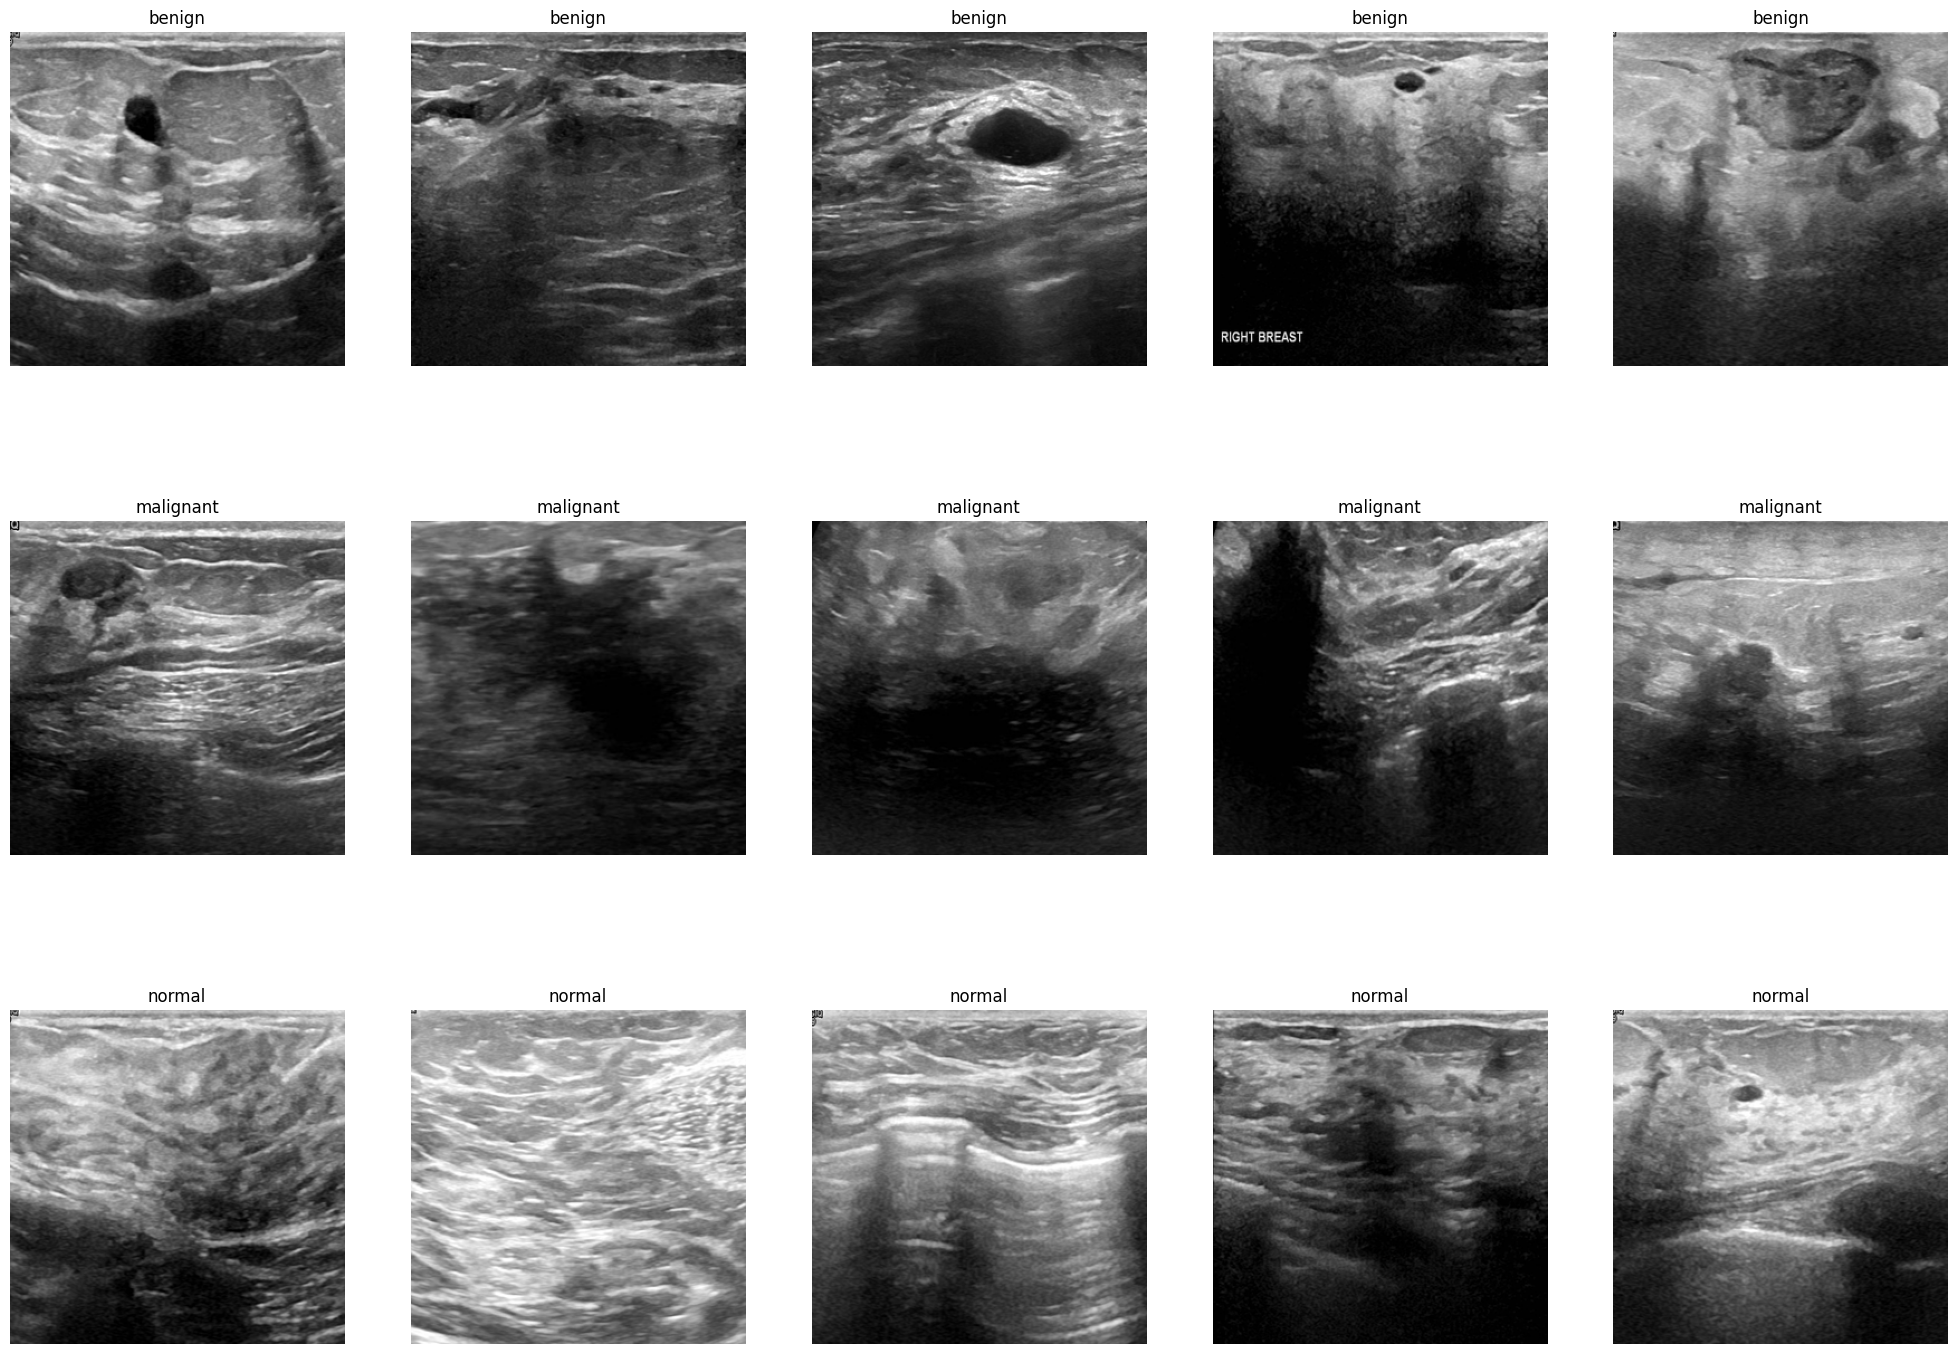

In [ ]:
train_dir = '/content/drive/MyDrive/working/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/content/drive/MyDrive/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")

test_dir = '/content/drive/MyDrive/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")


train_dir = '/content/drive/MyDrive/working/train'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

fig, axs = plt.subplots(3, 5, figsize=(25, 18))

desired_width = 300
desired_height = 300

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.LANCZOS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')


data_dir='/content/drive/MyDrive/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}


In [ ]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix 1:")
    print(cm)

    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 45.6MB/s]


Epoch 0/19
----------
train Loss: 0.8591 Acc: 0.6128
validation Loss: 0.6534 Acc: 0.7400

Epoch 1/19
----------
train Loss: 0.5907 Acc: 0.7655
validation Loss: 0.5158 Acc: 0.7900

Epoch 2/19
----------
train Loss: 0.4726 Acc: 0.8188
validation Loss: 0.4794 Acc: 0.8100

Epoch 3/19
----------
train Loss: 0.3756 Acc: 0.8632
validation Loss: 0.4820 Acc: 0.7700

Epoch 4/19
----------
train Loss: 0.3400 Acc: 0.8828
validation Loss: 0.4635 Acc: 0.8100

Epoch 5/19
----------
train Loss: 0.2615 Acc: 0.9094
validation Loss: 0.4227 Acc: 0.8200

Epoch 6/19
----------
train Loss: 0.2521 Acc: 0.9076
validation Loss: 0.5293 Acc: 0.7900

Epoch 7/19
----------
train Loss: 0.1900 Acc: 0.9414
validation Loss: 0.5318 Acc: 0.8000
Early stopping after 7 epochs
Training complete in 44m 45s
Best val Loss: 0.4227
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88        56
   malignant       0.83      0.74      0.78        27
      normal       0.65      0.76    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


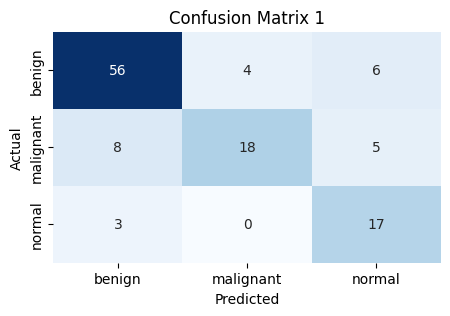

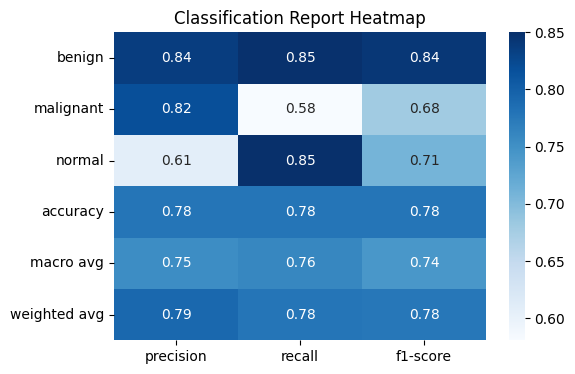

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.835821   0.818182  0.607143  0.777778   0.753715      0.792057
recall     0.848485   0.580645  0.850000  0.777778   0.759710      0.777778
f1-score   0.842105   0.679245  0.708333  0.777778   0.743228      0.776087


In [ ]:
# Load the pretrained model
DenseNet121 = models.densenet121(pretrained=True)

# Set requires_grad = True for all parameters
for param in DenseNet121.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = DenseNet121.classifier.in_features

# Replace the last layer with a new one with output features equal to the number of classes
DenseNet121.classifier = nn.Linear(in_features, len(class_names))

# Move the model to the device
DenseNet121_fineTuning = DenseNet121.to(device)

# Define the optimizer
optimizer = optim.Adam(DenseNet121_fineTuning.parameters(), lr=0.00005)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning1 = train_model_with_early_stopping(
    DenseNet121_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)

# Save the model
torch.save(model_fineTuning1, "/content/drive/MyDrive/working/DenseNet121_approach1.keras")

label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning1.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning1(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

In [ ]:
# Set the path to the Kaggle working directory
working_dir = '/content/drive/MyDrive/working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("working directory has been cleared.")

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

input_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

output_dir = '/content/drive/MyDrive/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_path):
    try:
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            if image.size != mask.size:
                image = image.resize(mask.size)

            overlayed = Image.blend(image, mask, alpha=0.5)

            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /content/drive/MyDrive/working/OverlayedImages directory.")

working directory has been cleared.
Overlayed images have been saved to /content/drive/MyDrive/working/OverlayedImages directory.


In [ ]:
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

input_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
output_dir = '/content/drive/MyDrive/working/OverlayedImages'

input_counts = {}
output_counts = {}

for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
normal: 266 files
benign: 891 files
malignant: 421 files

File Counts After Overlay:
benign: 437 files
malignant: 210 files
normal: 133 files


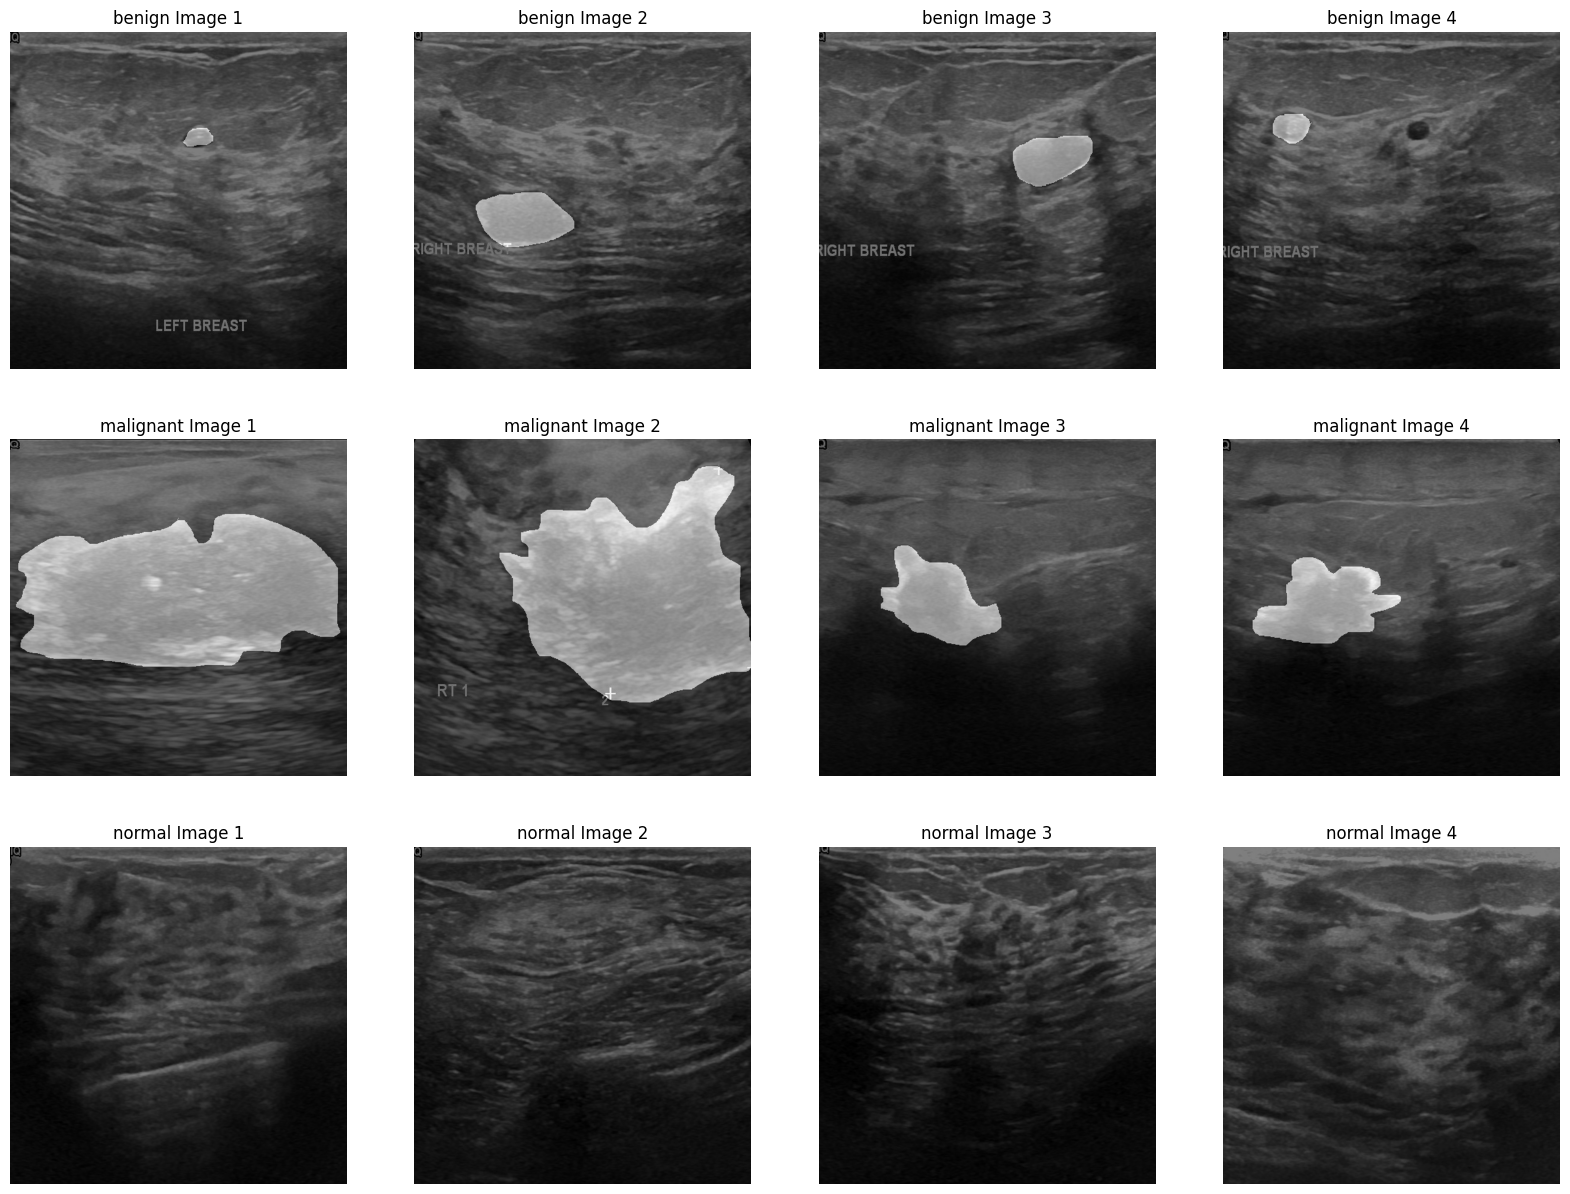

In [ ]:
overlayed_dir = '/content/drive/MyDrive/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

desired_width = 800
desired_height = 800

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))

    for j, image_filename in enumerate(images[:4]):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

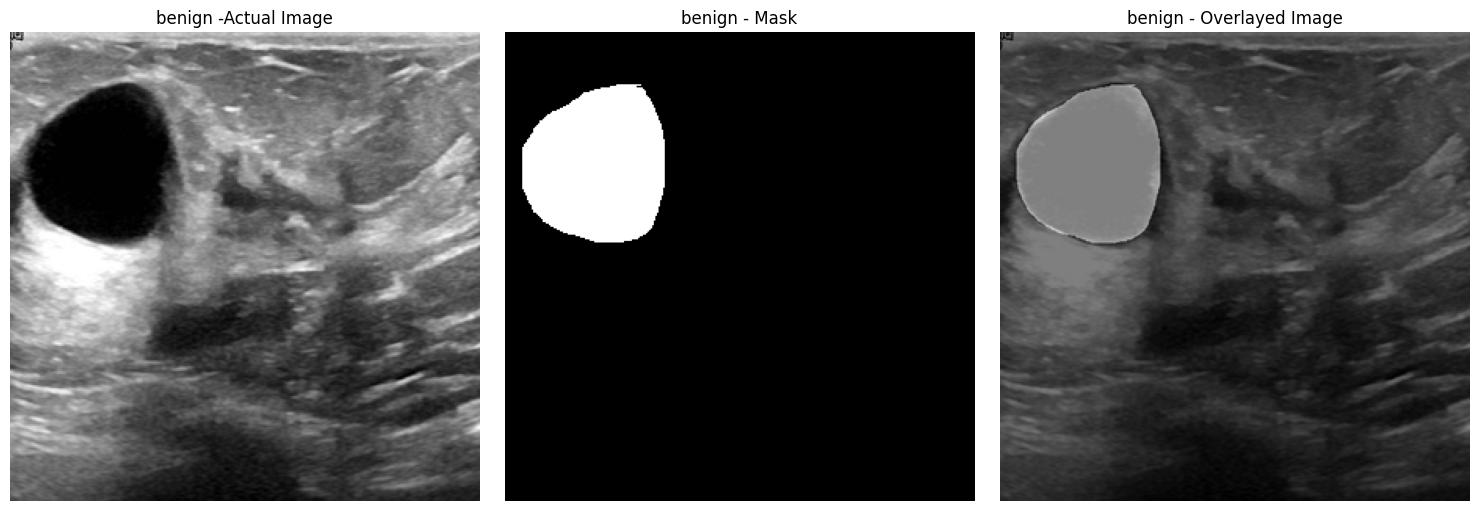

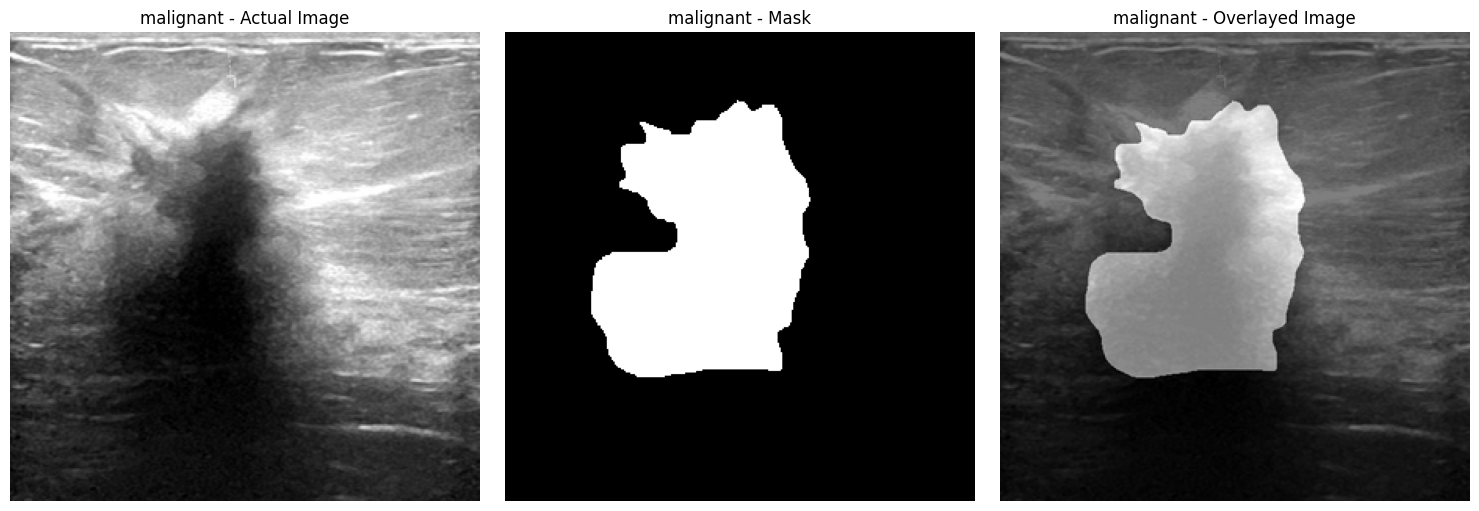

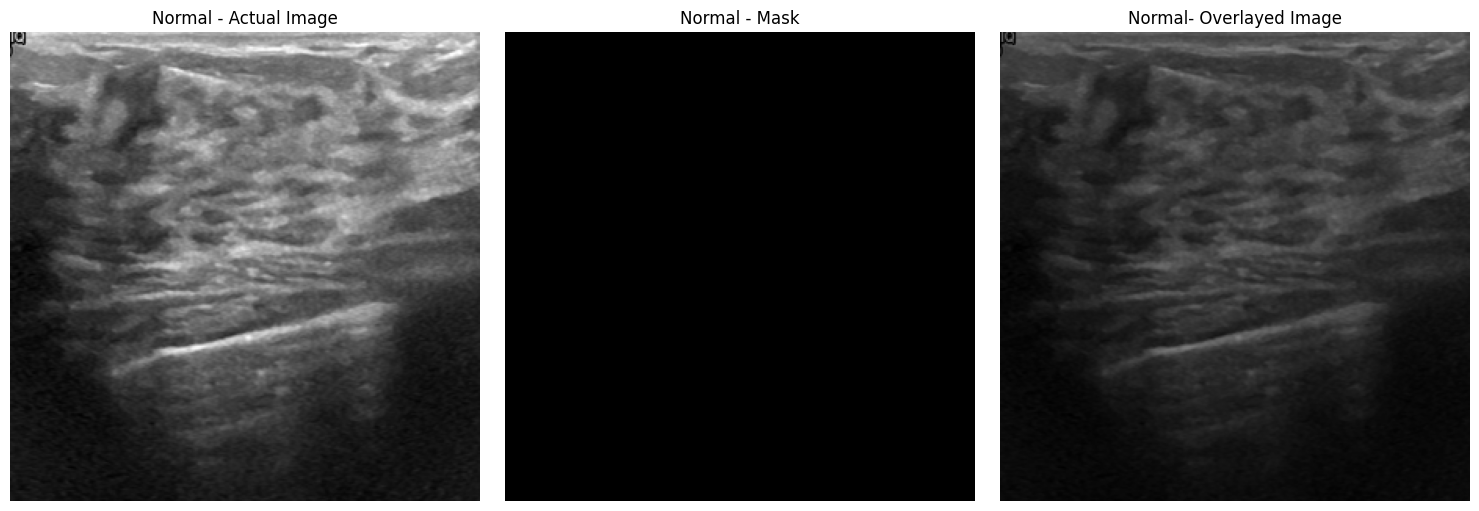

In [ ]:
input_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '/content/drive/MyDrive/working/OverlayedImages/benign'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'benign (10).png'

actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


input_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '/content/drive/MyDrive/working/OverlayedImages/malignant'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'malignant (103).png'

actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

input_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '/content/drive/MyDrive/working/OverlayedImages/normal'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'normal (1).png'

actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/working/OverlayedImages'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

In [ ]:
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/content/drive/MyDrive/working/train'
val_dir = '/content/drive/MyDrive/working/validation'
test_dir = '/content/drive/MyDrive/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))


file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/content/drive/MyDrive/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")


test_dir = '/content/drive/MyDrive/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")

data_dir='/content/drive/MyDrive/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


In [ ]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

train_dir = '/content/drive/MyDrive/working/train'

subdirectories = ['benign', 'malignant', 'normal']

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/19
----------
train Loss: 0.5729 Acc: 0.7993
validation Loss: 0.1612 Acc: 0.9800

Epoch 1/19
----------
train Loss: 0.2283 Acc: 0.9467
validation Loss: 0.0779 Acc: 0.9800

Epoch 2/19
----------
train Loss: 0.1710 Acc: 0.9556
validation Loss: 0.0908 Acc: 0.9800

Epoch 3/19
----------
train Loss: 0.0947 Acc: 0.9769
validation Loss: 0.0383 Acc: 0.9900

Epoch 4/19
----------
train Loss: 0.1160 Acc: 0.9609
validation Loss: 0.0247 Acc: 0.9900

Epoch 5/19
----------
train Loss: 0.0674 Acc: 0.9822
validation Loss: 0.0293 Acc: 0.9900

Epoch 6/19
----------
train Loss: 0.0685 Acc: 0.9858
validation Loss: 0.0270 Acc: 0.9900
Early stopping after 6 epochs
Training complete in 39m 25s
Best val Loss: 0.0247
              precision    recall  f1-score   support

      benign       0.98      1.00      0.99        56
   malignant       1.00      0.96      0.98        27
      normal       1.00      1.00      1.00        17

    accuracy                           0.99       100
   macro avg      

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


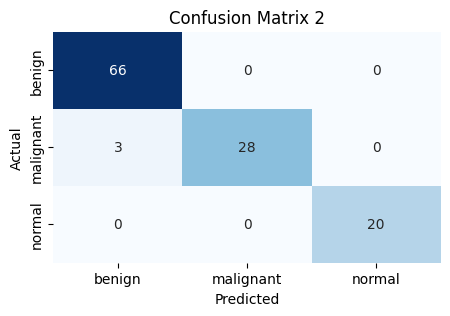

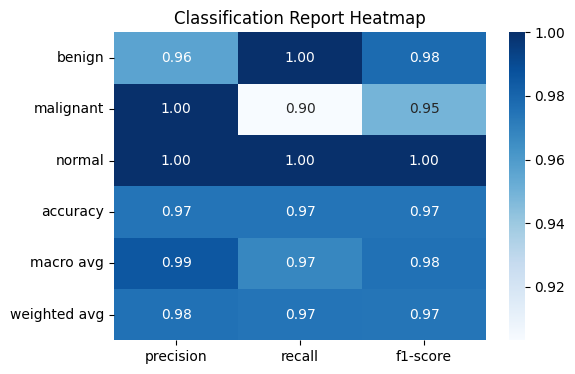

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.956522   1.000000     1.0  0.974359   0.985507      0.975474
recall     1.000000   0.903226     1.0  0.974359   0.967742      0.974359
f1-score   0.977778   0.949153     1.0  0.974359   0.975643      0.973992


In [ ]:
# Load the pretrained model
DenseNet121 = models.densenet121(pretrained=True)

# Set requires_grad = True for all parameters
for param in DenseNet121.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = DenseNet121.classifier.in_features

# Replace the last layer with a new one with output features equal to the number of classes
DenseNet121.classifier = nn.Linear(in_features, len(class_names))

# Move the model to the device
DenseNet121_fineTuning = DenseNet121.to(device)

# Define the optimizer
optimizer = optim.Adam(DenseNet121_fineTuning.parameters(), lr=0.00005)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning2 = train_model_with_early_stopping(
    DenseNet121_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)


label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning2.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning2(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


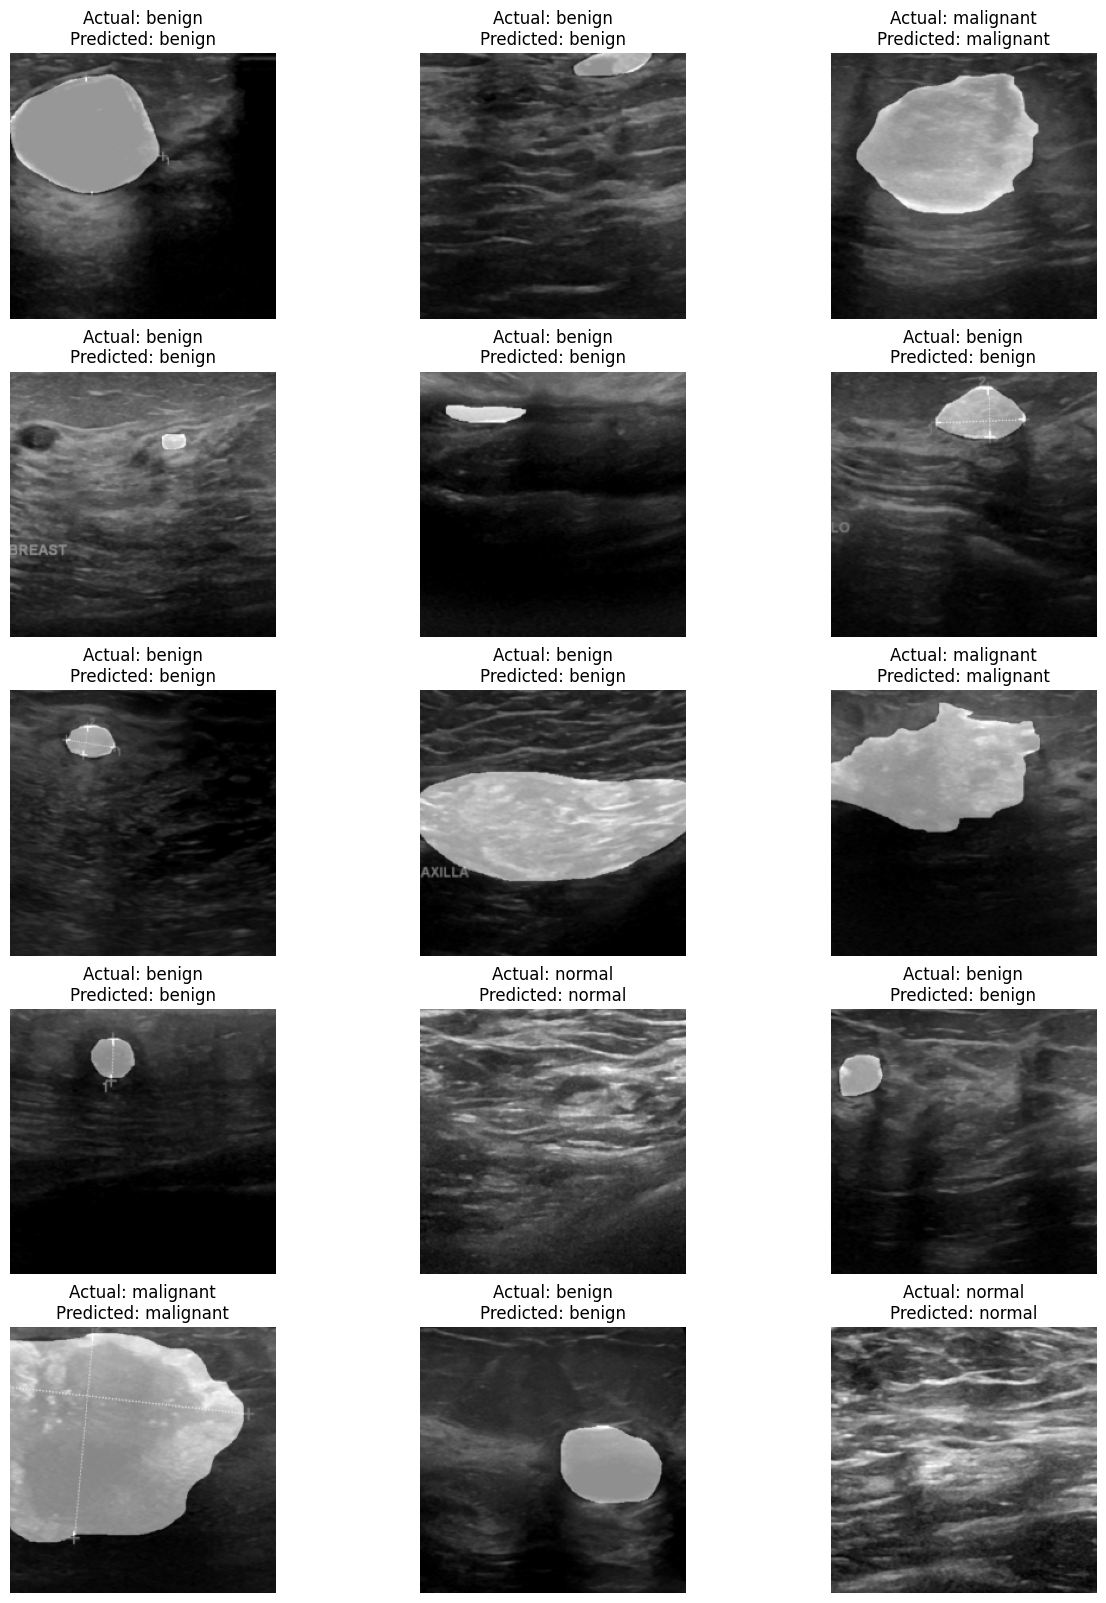

In [ ]:
num_images_to_display = 15

test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

inputs, labels = next(iter(test_dataloader))

inputs = inputs.to(device)

grayscale_images = inputs.cpu().numpy().mean(axis=1)

with torch.no_grad():
    model_fineTuning2.eval()
    outputs = model_fineTuning2(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 20))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')

plt.show()

(7, 7)


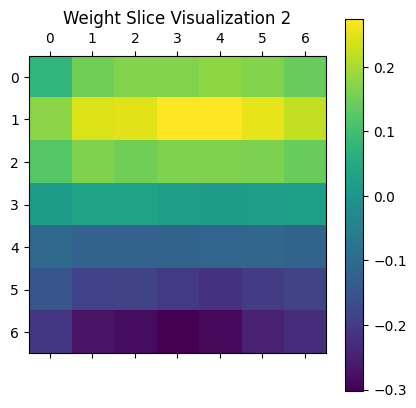

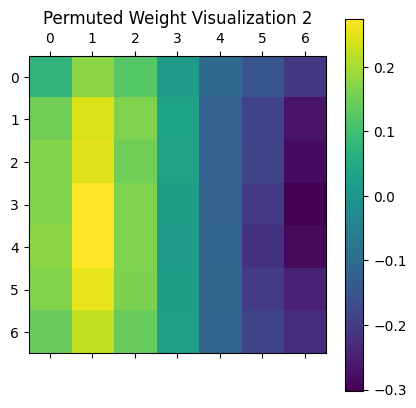

Slice Matrix 2=  [[ 0.07825735  0.1496248   0.16626683  0.16618747  0.1767335   0.16586852
   0.14109744]
 [ 0.17557615  0.24423176  0.25020397  0.27501252  0.27453202  0.25254568
   0.22214955]
 [ 0.12341291  0.16454889  0.14938742  0.16325462  0.16301592  0.16198647
   0.14072244]
 [ 0.01673097  0.03359896  0.02969246  0.0222686   0.01548425  0.01954648
   0.02442951]
 [-0.10455215 -0.12052272 -0.11954195 -0.11902601 -0.11352979 -0.11172748
  -0.11639123]
 [-0.14744839 -0.18648608 -0.18256915 -0.2032238  -0.21692628 -0.20212168
  -0.18286693]
 [-0.20725256 -0.27107233 -0.2814183  -0.30158585 -0.2870558  -0.24868932
  -0.2258556 ]]
permuted Matrix 2=  [[ 0.07825735  0.17557615  0.12341291  0.01673097 -0.10455215 -0.14744839
  -0.20725256]
 [ 0.1496248   0.24423176  0.16454889  0.03359896 -0.12052272 -0.18648608
  -0.27107233]
 [ 0.16626683  0.25020397  0.14938742  0.02969246 -0.11954195 -0.18256915
  -0.2814183 ]
 [ 0.16618747  0.27501252  0.16325462  0.0222686  -0.11902601 -0.2032238

In [ ]:
conv = next(m for m in model_fineTuning2.modules() if isinstance(m, torch.nn.Conv2d))
weights = conv.weight

slice = weights[0,0,:,:]

slice = slice.detach()

slice = slice.cpu()

slice_np = slice.numpy()

print(slice_np.shape)

plt.matshow(slice_np)
plt.title("Weight Slice Visualization 2")
plt.colorbar()
plt.show()

permuted = np.transpose(slice_np, (1,0))

plt.matshow(permuted)
plt.title("Permuted Weight Visualization 2")
plt.colorbar()
plt.show()

print("Slice Matrix 2= ",slice_np)


print("permuted Matrix 2= ",permuted)

In [ ]:
torch.save(model_fineTuning2,"/content/drive/MyDrive/working/DenseNet121_approach2.keras")
print(f'models saved in {working_dir} successfully!')

models saved in /content/drive/MyDrive/working successfully!
